# Stance Detection using Network Partitioning

## Code by Paolo Cornale

source: https://metis.readthedocs.io/en/latest/

http://glaros.dtc.umn.edu/gkhome/metis/metis/download

In this notebook, we use METIS network partitioning algorithm to perform community detection in a retweet network. The topic here is Ukraine conflict, discussed in Italian language.

METIS is used to get the best splitting into three partitions: the two main sides, plus the group of users that do have not a clear leaning. I called them, respectively, Side 0, Side 1, and Side 05. This algorithm provides a score S between 0 and 1 for each node of the graph which represents its leaning toward one of the two communities.

First, we need to optimize the hyperparameters "ufact" and "threshold" of METIS algorithm.

The parameter "ufact" keeps the partitions balanced in side by specifying how many per thousand away from 1 the imbalance is allowed to be. It is optimized by exploring its space of possible values, by making 100 iterations of METIS for each value of the hyperparameter, but starting with different seeds. This procedure produces an ensemble of 100 scores (basically a list of 0 or 1) for each node of the graph. The definitive value of one score is the mean of the scores obtained. We select the ufact value that maximizes the number of users having a score within a 95% confidence interval from either extreme (see Cossard et al., 2020). 

Further, we fix the threshold τ to 0.04, so that if the score is <= 0.04 we consider it equal to 0 if it is <= 1.96, we consider it equal to 1, otherwise, we fix it as 0.5 (i.e. the "undecided" nodes). This threshold is fixed by the Clopper-Pearson confident interval applyied to the binomial distribution of the scores of each node.

Citation:

Cossard, A., Morales, G. D. F., Kalimeri, K., Mejova, Y., Paolotti, D., & Starnini, M. (2020, May). Falling into the echo chamber: the Italian vaccination debate on Twitter. In Proceedings of the International AAAI conference on web and social media (Vol. 14, pp. 130-140).

In [1]:
pip install metis

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import networkx as nx
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import metis
import csv
import sys

Read in the edge list.

In [2]:
data_folder = "data/" 
df_GCC_edges = pd.read_csv( data_folder + "4_final_edges_NEW.csv")
df_GCC_edges

,Source,Target,Type,Id,Label,timeset,Weight
0,1.292022e+09,2.498146e+09,Directed,0,NaN,NaN,3
1,1.097175e+18,1.292022e+09,Directed,78591,NaN,NaN,2
2,2.498146e+09,3.091392e+09,Directed,36277,NaN,NaN,2
3,2.498146e+09,5.991145e+08,Directed,22774,NaN,NaN,4
4,1.441340e+18,2.498146e+09,Directed,141437,NaN,NaN,2
...,...,...,...,...,...,...,...
15236,1.472674e+18,8.188372e+17,Directed,135281,NaN,NaN,2
15237,1.724220e+07,8.188372e+17,Directed,135213,NaN,NaN,2
15238,1.578412e+18,8.188372e+17,Directed,135206,NaN,NaN,2
15239,1.715245e+07,8.188372e+17,Directed,135196,NaN,NaN,2


METIS expects an undirected graph as input: hence we cannot use transform the directed graph of the retweet network to an undirected one with nx.Graph. For this reason we lose few egdes.

In [3]:
G3 = nx.from_pandas_edgelist(df_GCC_edges, source="Source", target="Target", edge_attr="Weight", create_using=nx.Graph())
G3.graph["edge_weight_attr"] = "Weight"
#G3.remove_edges_from(G3.selfloop_edges())

In [4]:
print(f'n={G3.number_of_nodes()} m={G3.number_of_edges()}')

n=14704 m=15181


ufact keep the partitions balanced in side by specifying how many per thousand away from 1 the imbalance is allowed to be. It is optimized by exploring its space of possible values, by making N = 100 iterations of METIS for each value of the hyperparameter, but starting with different seeds. This procedure produces an ensemble of 100 scores (basically a list of 0 or 1) for each node of the graph. The definitive value of one score is the mean of the scores obtained. We selected the ufact value that maximizes the number of users having a score within a 95% confidence interval from either extreme.

To use the Clopper–Pearson interval (its computation has a relation with the beta distribution) to compute the binomial 95% confidence interval: N = 100 (or 0), alpha = 0.05 --> threshold = 0.04:

In [6]:
from scipy.stats import beta
k = 0
n = 100
alpha = 0.05
p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n - k])
print(p_u, p_o)

k = 100  #symmetrical
p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n - k])
print(p_u, p_o)

nan 0.03621669264517641
0.9637833073548235 nan


1- 0.964 = 0.036 ~ 0.04 = threshold

"In METIS, graphs are represented with arrays. Given a graph of v vertices, vertices are implicitly labeled
0, 1, 2,..., v − 1. Information on edges is held in two arrays: xadj and adjncy. For all vertices i, the list of
vertices adjacent to i are listed in the array adjncy from elements xadj[i] inclusive to xadj[i+ 1]) exclusive.
Thus, for xadj[i] <= j < xadj[i + 1], the value of adjncy[j] is connected to the vertex i. The array adjwgt
holds the edge weights, thus adjwgt[j] holds the edge weight of adjncy[j]." (from "Partial Parallelization of Graph Partitioning Algorithm METIS" https://ocw.mit.edu/courses/6-895-theory-of-parallel-systems-sma-5509-fall-2003/6f825562feec8333c6a400a67f1bfebd_kasheff.pdf)


We use the function **metis.part_graph** which parameters are: 

1) **graph** (the graph object, in this case G3, that has to be partitioned)        
2) **nparts** (the nr of partitions that the algorithm search, in this case 2)         
3) **seed** (the RNG (Random Number Generator) seed, i.e. the starting node for the application of the first phase of METIS (the coarsening of the original graph))          
4) **ufactor** (integer, maximum load imbalance of the partition computed as: (1+x)/1000 )         


The function metis.part_graph returns a 2-tuple (objval, parts), where parts is a list of partition indices corresponding and objval is the value of the objective function that was minimized (either the edge cuts (as in my case) or the total volume).

On each iteration, the indeces have local meaning and are useful only to distinguish in a topological way the two extreme sides. We made 100 iterations, and we want that the index 0, for example, represent the same side for each iteration and same for the other indeces. The "identity" of the partition has to remain the same for each itaration of the algorithm. To check this, we define the first side as the closest one to the centroid of the partition assignments, and we check if this condition is always satisfy (if it is not, we switch index, by taking the complementary assignment).

Finally we compute the mean of nodes assigned to one of the two sides (with the defined threshold), and we choose the ufactor that maximizes the assigned nodes.

In [8]:
# code to optimize ufactor
side_ufactor = {}
for ufactor in range(5,90,5):
    edgecuts_a = []
    parts_df = pd.DataFrame()
    N = 100
    threshold = 0.04
    for i in range(N):
        edgecuts, parts = metis.part_graph(G3, 2, seed=i, ufactor=ufactor*10) #ufactor is in per thousant but I want it in %
        parts = pd.Series(parts)
        if not parts_df.empty:
            # compute centroid of partition assignments 
            
            #QUESTION ABOUT THIS PART: SEE QUESTION 2 ABOVE
            centroid = parts_df.mean(axis=1)
            d1 = (centroid - parts).abs().sum()
            d2 = (centroid - (1-parts)).abs().sum()
            if d2 < d1:
                parts = 1 - parts # take the complement of assignments if it is closer to the centroid
            edgecuts_a.append(edgecuts)
        parts_df[f's{i}'] = parts
        sys.stdout.write(f'\r{i}/{N}')
    sys.stdout.write(f'\r')
    ones = parts_df.sum(axis=1)
    side = parts_df.mean(axis=1)
    n0 = side[side<=threshold].count() 
    n1 = side[side>=1-threshold].count()
    print(f'ufactor={ufactor}%, frac_within_t={(n0+n1)/len(side)}')
    side_ufactor[ufactor]=side

ufactor=5%, frac_within_t=0.6499591947769314
ufactor=10%, frac_within_t=0.6422742110990207
ufactor=15%, frac_within_t=0.6458106637649619
ufactor=20%, frac_within_t=0.6542437431991295
ufactor=25%, frac_within_t=0.6530195865070729
ufactor=30%, frac_within_t=0.651183351468988
ufactor=35%, frac_within_t=0.6197633297062024
ufactor=40%, frac_within_t=0.6315968443960827
ufactor=45%, frac_within_t=0.3429678998911861
ufactor=50%, frac_within_t=0.1927366702937976
ufactor=55%, frac_within_t=0.320252992383025
ufactor=60%, frac_within_t=0.3945865070729053
ufactor=65%, frac_within_t=0.40118335146898804
ufactor=70%, frac_within_t=0.39921109902067464
ufactor=75%, frac_within_t=0.3992791077257889
ufactor=80%, frac_within_t=0.3696273122959739
ufactor=85%, frac_within_t=0.3237894450489663


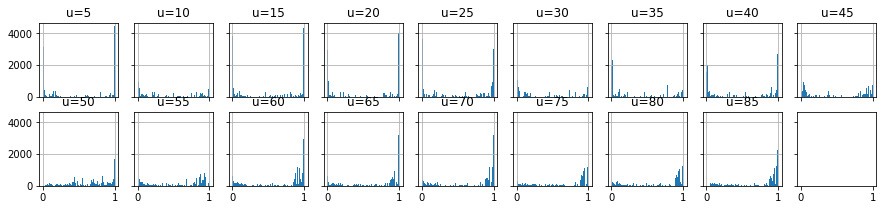

In [9]:
r = 2
c = int(np.ceil(len(side_ufactor.keys())/r))
fig, axes = plt.subplots(r, c, sharey=True, sharex=True, figsize=(15,3))
for i,k in enumerate(side_ufactor.keys()):
    side_ufactor[k].hist(bins=100, ax=axes[i//c][i%c])
    axes[i//c][i%c].set_title(f'u={k}')

The highest values of the faction of nodes inside the 95% confidence interval is for the values of ufact belonging to the [10, 40] range. Thus, we focus on this interval. 

In [10]:
# code to optimize ufactor
side_ufactor = {}
for ufactor in range(10,40,1):
    edgecuts_a = []
    parts_df = pd.DataFrame()
    N = 100
    threshold = 0.04
    for i in range(N):
        edgecuts, parts = metis.part_graph(G3, 2, seed=i, ufactor=ufactor*10)
        parts = pd.Series(parts)
        if not parts_df.empty:
            # copmute centroid of partition assignments
            centroid = parts_df.mean(axis=1)
            d1 = (centroid - parts).abs().sum()
            d2 = (centroid - (1-parts)).abs().sum()
            if d2 < d1:
                parts = 1 - parts # take the complement of assignments if it is closer to the centroid
            edgecuts_a.append(edgecuts)
        parts_df[f's{i}'] = parts
        sys.stdout.write(f'\r{i}/{N}')
    sys.stdout.write(f'\r')
    ones = parts_df.sum(axis=1)
    side = parts_df.mean(axis=1)
    n0 = side[side<=threshold].count()
    n1 = side[side>=1-threshold].count()
    print(f'ufactor={ufactor}%, frac_within_t={(n0+n1)/len(side)}')
    side_ufactor[ufactor]=side

ufactor=10%, frac_within_t=0.6422742110990207
ufactor=11%, frac_within_t=0.6499591947769314
ufactor=12%, frac_within_t=0.6493471164309031
ufactor=13%, frac_within_t=0.6603645266594124
ufactor=14%, frac_within_t=0.6476468988030468
ufactor=15%, frac_within_t=0.6458106637649619
ufactor=16%, frac_within_t=0.6587323177366703
ufactor=17%, frac_within_t=0.6541757344940152
ufactor=18%, frac_within_t=0.6580522306855278
ufactor=19%, frac_within_t=0.6579842219804135
ufactor=20%, frac_within_t=0.6542437431991295
ufactor=21%, frac_within_t=0.6441784548422198
ufactor=22%, frac_within_t=0.6530875952121872
ufactor=23%, frac_within_t=0.6577801958650707
ufactor=24%, frac_within_t=0.6337051142546246
ufactor=25%, frac_within_t=0.6530195865070729
ufactor=26%, frac_within_t=0.6422062023939065
ufactor=27%, frac_within_t=0.6406420021762785
ufactor=28%, frac_within_t=0.6512513601741022
ufactor=29%, frac_within_t=0.6505712731229597
ufactor=30%, frac_within_t=0.651183351468988
ufactor=31%, frac_within_t=0.650299

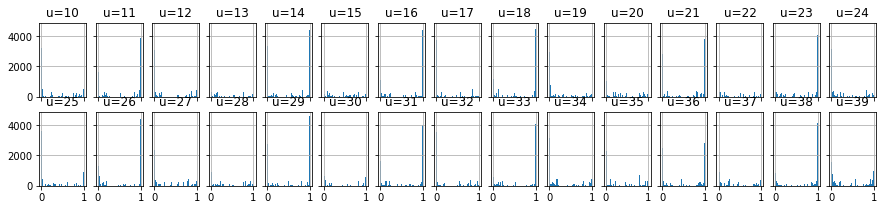

In [11]:
r = 2
c = int(np.ceil(len(side_ufactor.keys())/r))
fig, axes = plt.subplots(r, c, sharey=True, sharex=True, figsize=(15,3))
for i,k in enumerate(side_ufactor.keys()):
    side_ufactor[k].hist(bins=100, ax=axes[i//c][i%c])
    axes[i//c][i%c].set_title(f'u={k}')

## Use the optimum value of ufactor to compute the final partitioning

In [12]:
#this is the partition code in which we put the uvalue optimized.
#It outputs the best partition of the network
edgecuts_a = []
parts_df = pd.DataFrame()
N = 100
ufactor = 39
for i in range(N):
    edgecuts, parts = metis.part_graph(G3, 2, seed=i, ufactor=ufactor*10)
    parts = pd.Series(parts)
    if not parts_df.empty:
        # copmute centroid of partition assignments
        centroid = parts_df.mean(axis=1)
        d1 = (centroid - parts).abs().sum()
        d2 = (centroid - (1-parts)).abs().sum()
        if d2 < d1:
            parts = 1 - parts # take the complement of assignments if it is closer to the centroid
        edgecuts_a.append(edgecuts)
    parts_df[f's{i}'] = parts
    sys.stdout.write(f'\r{i}/{N}')
sys.stdout.write(f'\r')

side = parts_df.mean(axis=1)
ci = pd.DataFrame()
ci['v'] = side
ci['w'] = 1.96 * np.sqrt(ci.v * (1-ci.v) / N) # 1.96 for 95% confidence intervals (use ~3 for 99% confidence intervals)
ci['lb'] = ci.v - ci.w
ci['ub'] = ci.v + ci.w
print(ci[ci.lb <= 0].v.max(), ci[ci.ub >= 1].v.min())
threshold = 0.04  #0.037

0.03 0.97


In [13]:
ufactor

39

Output statistics about the nodes that fall on one or another side of the network.

If the score is lower than 0.04 we consider it 0, if it is higher than 1.96 we consider it equal to 1. otherwise we fix it as 0.5. Hence, we have two communities (0 and 1) and some "undecided" nodes (with scores of 0,5) in the middle.

GCC_SUB |V|=14704, #_side0=4418, #_side1=4673, #_neutral=5613
%_side0=0.300, %_side1=0.318, %_neutral=0.382


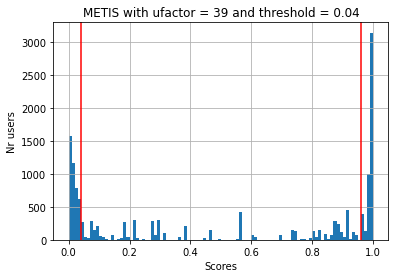

In [14]:
side.hist(bins=100)
n  = G3.number_of_nodes()
n0 = side[side<=threshold].count()
n1 = side[side>=1-threshold].count()
print(f'GCC_SUB |V|={n}, #_side0={n0}, #_side1={n1}, #_neutral={n-n0-n1}')
print(f'%_side0={n0/n:.3f}, %_side1={n1/n:.3f}, %_neutral={(n-n0-n1)/n:.3f}')





plt.savefig('partitioning_metis.png')
plt.axvline(x=0.04, c='r')
plt.axvline(x=0.96, c='r')
plt.xlabel("Scores")
plt.ylabel("Nr users")
plt.title(f"METIS with ufactor = {ufactor} and threshold = 0.04")
plt.show()

The above network can then be visualized. We can see that, indeed, the network is well separated into two halves: 0 (= red), 1 (=blue), 05 (=green). The plot shows the 3 users with the highest non-weighted in-degree for each side.

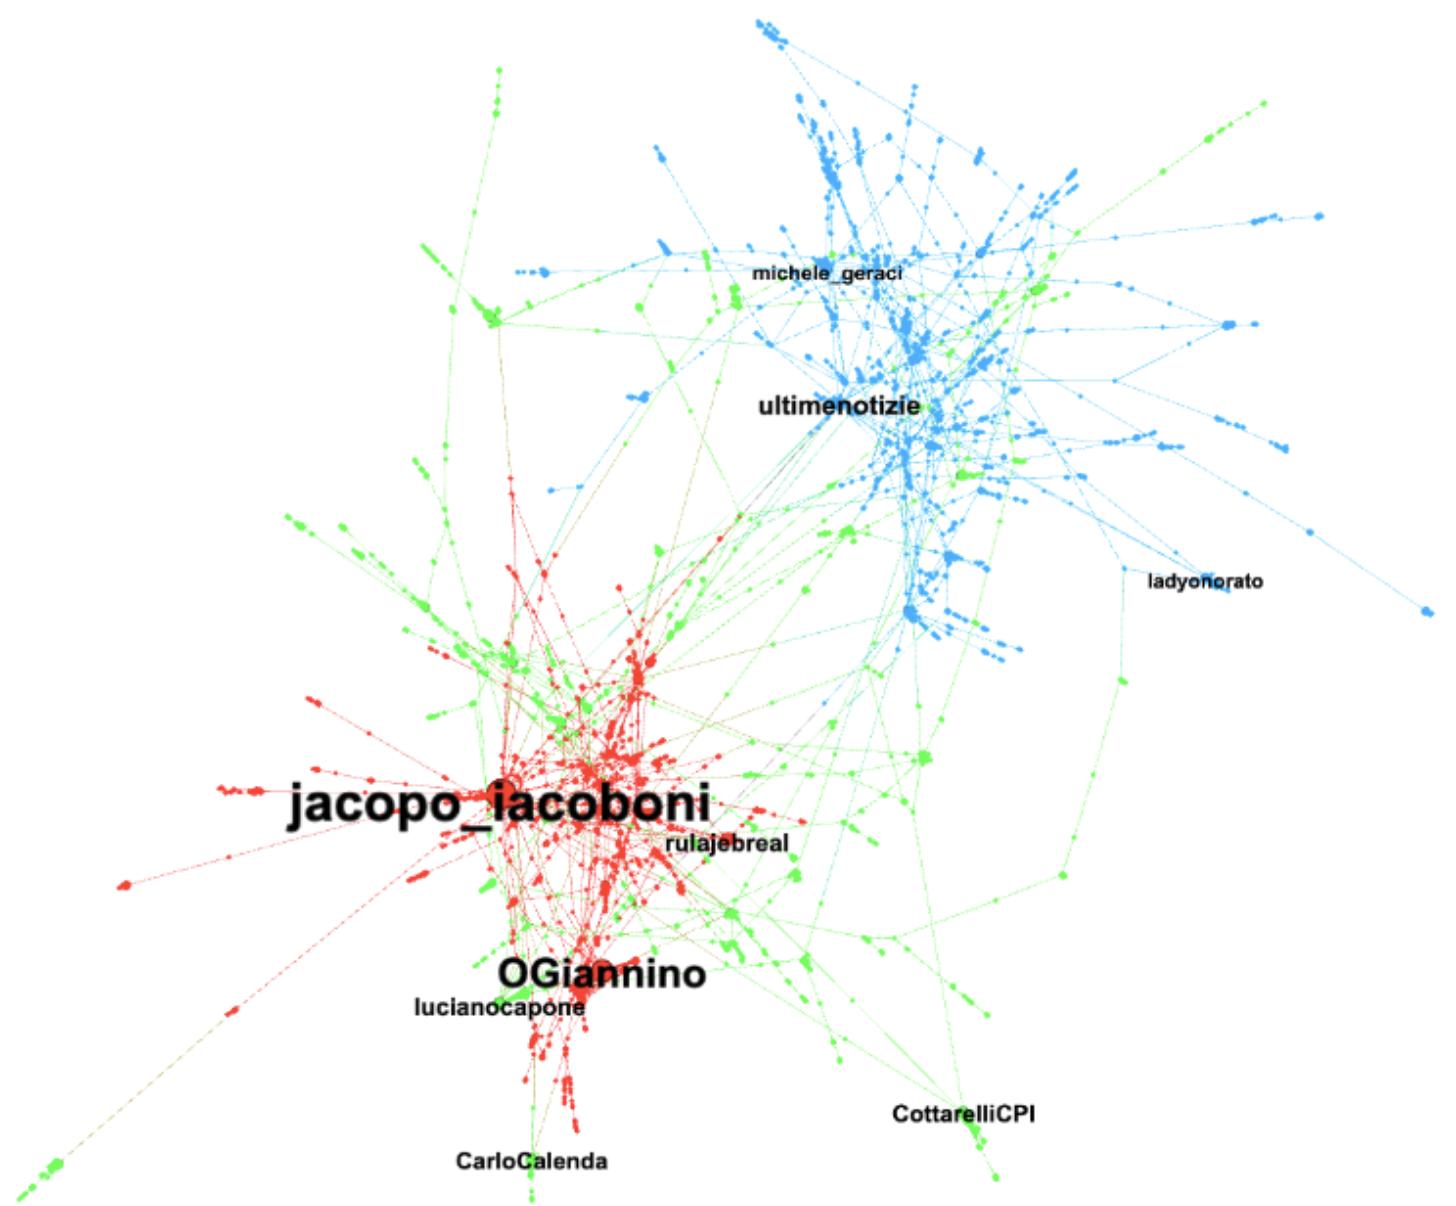

We can then examine the top posters in each "community", and the content they share:

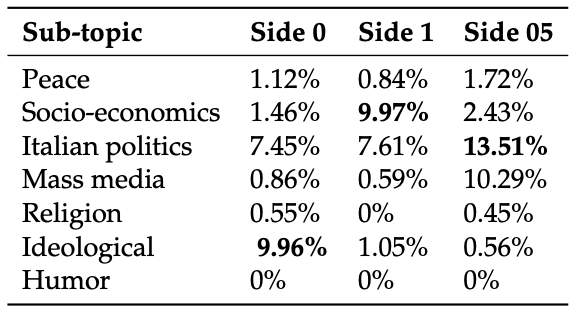